# Check UI<sub>Ek</sub>
* what happens if I acutally calculate it along the coast and at a 90° angle to the coast...?
    * calculate the angle 90° to coastline
    * get the Ekman transport at mid-shelf (same line I use for UI<sub>SST</sub> and UI<sub>SSH</sub>
* calculate new mean UI<sub>Ek</sub> and compare to old verison
* check correlation with other values

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import LineString, MultiLineString
import numpy as np
import xarray as xr
import my_functions
from scipy.stats import pearsonr
import os

In [2]:
## load data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]
MTSS = xr.open_dataset('MTSS_weekly.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
Angles = xr.open_dataset('Angles_coast.nc')

## Data Prep

In [3]:
## selct common period MTSS and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [19]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek
Ek = MTSS
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm), 
                                       near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [20]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [21]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(SST)
SSH_summer = my_functions.subset_summer(SSH)

## Functions

In [7]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label', add_contour = False, 
             save = False, save_fig_as = 'map'):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.8)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);

    if add_contour == True:
        clp = DS.plot.contour(colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
        plt.clabel(clp, fontsize = 7)
    
    plt.title(f'{title}')
    
    if save == True:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

## Get Angles

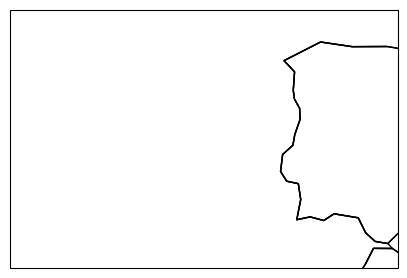

In [7]:
## Create a map projection and extract lat and lon values of coastline 
# adapted from chatGPT
projection = ccrs.PlateCarree()

# Create a figure and add axes with the specified projection
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': projection})

# Set the geographical extent of the plot to the region of interest
ax.set_extent([-20, -5, 35, 45], crs=projection)
ax.coastlines(resolution='110m')  # Set resolution to '50m'

# Add a feature for the coastlines to extract the coordinates
coastlines = cfeature.NaturalEarthFeature(
    'physical', 'coastline', '110m', edgecolor='k', facecolor='none')  # Set resolution to '50m'

ax.add_feature(coastlines)

# Initialize lists to store coordinates
longitudes = []
latitudes = []

# Extract and plot the coordinates of the coastlines
def plot_and_collect_coords(geometry):
    if isinstance(geometry, (LineString, MultiLineString)):
        if isinstance(geometry, LineString):
            geometries = [geometry]
        else:
            geometries = geometry.geoms
        
        for geom in geometries:
            x, y = geom.xy
            for lon, lat in zip(x, y):
                if -20 <= lon <= -5 and 35 <= lat <= 45:
                    longitudes.append(lon)
                    latitudes.append(lat)

for geometry in coastlines.geometries():
    plot_and_collect_coords(geometry)

# Convert lists to numpy arrays
longitudes = np.array(longitudes)
latitudes = np.array(latitudes)

coords = np.column_stack((longitudes, latitudes))

# Plot the coordinates
ax.plot(longitudes, latitudes, 'k', linewidth=1)

# Display the plot
plt.show()


In [8]:
# get the points that lie in between the points where I want data later
# my logic is that I can assign the value that I calculated between 34.875 and 35.125 to 35 
# -> this makes sense because the value gives me the angle of the coast between these two latitudes i.e. at 35°N
new1_lat = np.arange(34.875, 45.125, 0.25) 
new1_lon = np.interp(new1_lat, coords[:,1], coords[:,0]) 

(35.0, 45.0)

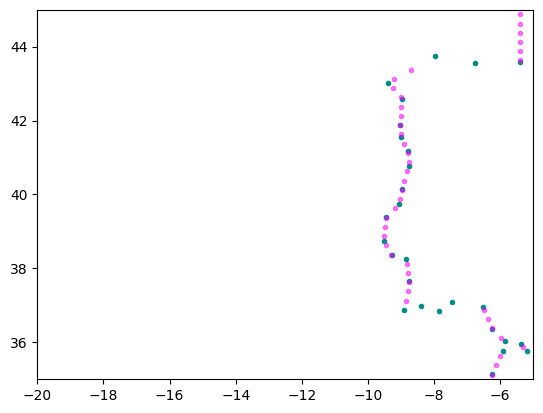

In [9]:
# unevenly spaced output from the function above
plt.scatter(coords[:,0], coords[:,1], marker = '.', color = 'darkcyan')
# evenly spaced (looses some info... especially north of Finisterre)
# interp function cannot deal with non sorted values... only a problem up here so I will leave it because
# the data north of 43.5°N are not relevant to my analysis later on
plt.scatter(new1_lon, new1_lat, marker = '.', color = 'magenta', alpha = 0.5) 
plt.xlim(-20,-5)
plt.ylim(35, 45)

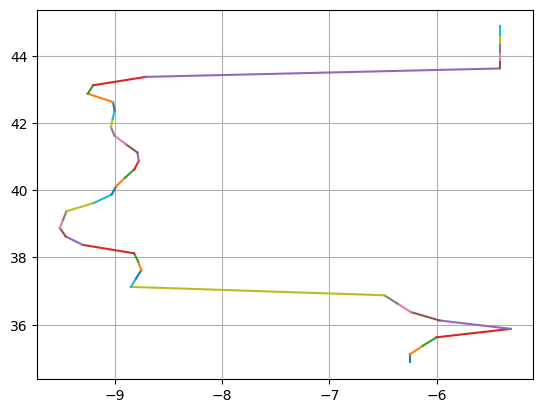

In [10]:
test = []
for i in np.arange(len(new1_lat)-1):
    deltaY = new1_lat[i] - new1_lat[i+1]
    deltaX = new1_lon[i] - new1_lon[i+1]
    
    if deltaX == 0:
        test.append(np.nan) # fill with nans where I would devide through 0 -> weird values anyway that I won't need later
    else:
        angle_in_rad = np.arctan(deltaY/deltaX) # * 180/ np.pi
        test.append(angle_in_rad)
    
    plt.plot(new1_lon[i:(i+2)], new1_lat[i:(i+2)])

plt.grid()        
test.append(np.nan) # fill last with nan -> at edge won't use later

In [12]:
# get the lats res I want
new2_lat = np.arange(35, 45.25, 0.25) 
new2_lon = np.interp(new2_lat, coords[:,1], coords[:,0]) 

# to get the direction at right angle towards the coast
# need to take into account if the angle of the shoreline is positive or negative
positive_mask = np.where(np.array(test) > 0)
negative_mask = np.where(np.array(test) < 0)

var_phi = np.zeros(len(test))
var_phi[positive_mask] = np.array(test)[positive_mask] - np.pi/2    
var_phi[negative_mask] = np.array(test)[negative_mask] + np.pi/2   

# theta 
#theta = np.zeros(len(test))
#theta[positive_mask] = var_phi[positive_mask] + np.pi/2    
#theta[negative_mask] = var_phi[negative_mask] - np.pi/2 

ds = np.column_stack((new2_lon, new2_lat, np.array(test), var_phi)) #, theta))

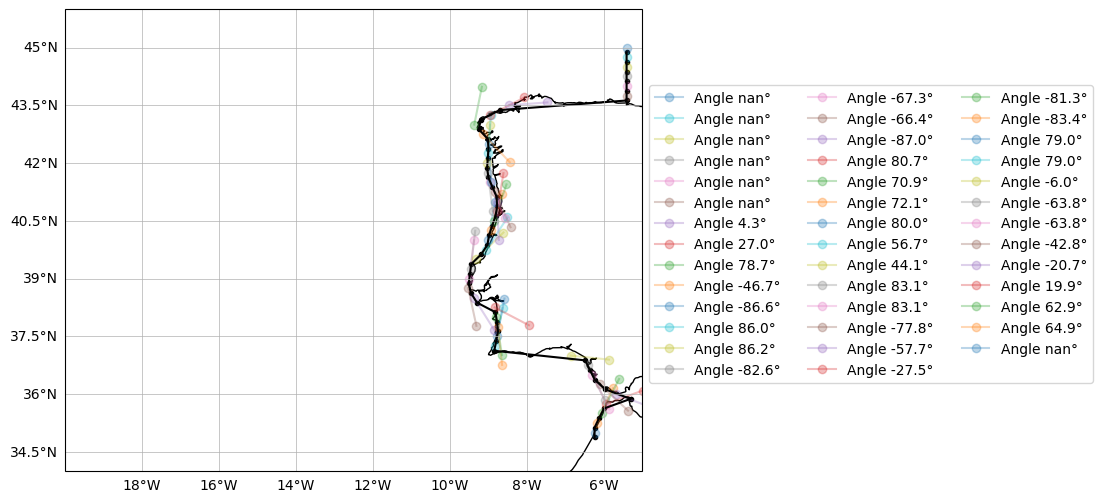

In [13]:
latitudes = ds[:,1] # Latitude coordinates
longitudes = ds[:,0] # Longitude coordinates
angles_rad = ds[:,2] # Angle in radians off shore direction

# Plotting
plt.figure(figsize=(10, 6))

# cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, -5, 46, 34])
ax.coastlines()
gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
gls.top_labels = False 
gls.right_labels = False 


# Iterate through each position
for lat, lon, angle_rad in zip(latitudes, longitudes, angles_rad):
    # Define line segment
    length = 1.0  # Length of the line segment
    dx = length * np.cos(angle_rad)
    dy = length * np.sin(angle_rad)

    # Plot line segment
    plt.plot([lon, lon + dx], [lat, lat + dy], marker='o', label=f'Angle {np.degrees(angle_rad):.1f}°', alpha = 0.3)

#plt.scatter(longitudes, latitudes, color = 'black', marker = 'o', alpha = 1)
plt.scatter(new1_lon, new1_lat, marker = '.', color = 'black')
#plt.plot(longitudes, latitudes, color = 'black', alpha = 0.5)
plt.plot(new1_lon, new1_lat, color = 'black')


# Add legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor = (1,0.85), ncol = 3)
plt.show()

# the black dots indicate the latitudes for inbetween which the direction 90° to shore was calculated 
# the coloured lines show the direction of the angle 90° away from shore

In [ ]:
## summarise the data in an xarray and save as netCDF file 
# define input variables
lon = ds[:,0]
lat = ds[:,1]
angle_shore = ds[:,2]
angle_phi = ds[:,3]
# angle_theta = ds[:,4]
coords = [lat, lon]

# define xarray
Angles = xr.Dataset(
    data_vars = dict(
        angle_shore = (["lat"], angle_shore),
        angle_phi = (["lat"], angle_phi),
#        angle_theta = (["lat"], angle_theta),
        lon = (["lon"], lon),
    ),
    coords = dict(
        lat = lat,
    ),
    attrs = dict(Description = "Relevant angles of the west coast of the Iberian Peninsula"),
)

# set attributes
Angles.angle_shore.attrs.update({'Name' : 'Angle of the coast', 'Units' : 'rad'})
Angles.angle_phi.attrs.update({'Name' : 'Angle at 90° to shore directed toward the coast', 'Units' : 'rad'})
# Angles.angle_theta.attrs.update({'Name' : 'Angle phi rotated 90° further', 'Units' : 'rad'})
Angles.lon.attrs.update({'Name' : 'Longitude', 'Info' : 'Exact longitude position of the measurement'})

# make all values north of 43.5 and south of 37.25 nans becuase I did not take care to calculate them
# correctly because they are not relevant here
Angles = Angles.where((Angles.lat >= 37) &  (Angles.lat <= 43.5))
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')



In [24]:
# save as net_cdf
Angles.to_netcdf('Angles_coast.nc')

In [16]:
Angles

<xarray.Dataset> Size: 1kB
Dimensions:      (lat: 41, lon: 41)
Coordinates:
  * lon          (lon) float64 328B -6.244 -6.191 -6.063 ... -5.412 -5.412
  * lat          (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
Data variables:
    angle_shore  (lat) float64 328B nan nan nan nan nan ... nan nan nan nan nan
    angle_phi    (lat) float64 328B nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Description:  Relevant angles of the west coast of the Iberian Peninsula

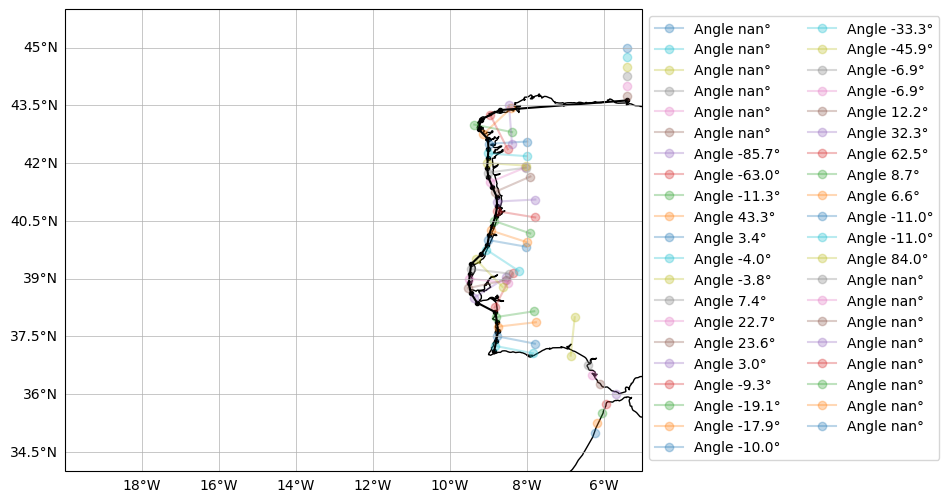

In [17]:
## where it is actually relevant (between 37.25°N and 43.5°N)
# Plotting

latitudes = Angles.lat
longitudes = Angles.lon
angles_rad = Angles.angle_phi

plt.figure(figsize=(10, 6))

# cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, -5, 46, 34])
ax.coastlines()
gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
gls.top_labels = False 
gls.right_labels = False 


# Iterate through each position
for lat, lon, angle_rad in zip(latitudes, longitudes, angles_rad):
    # Define line segment
    length = 1.0  # Length of the line segment
    dx = length * np.cos(angle_rad)
    dy = length * np.sin(angle_rad)

    # Plot line segment
    plt.plot([lon, lon + dx], [lat, lat + dy], marker='o', label=f'Angle {np.degrees(angle_rad):.1f}°', alpha = 0.3)

#plt.scatter(longitudes, latitudes, color = 'black', marker = 'o', alpha = 1)
plt.scatter(new1_lon[9:-5], new1_lat[9:-5], marker = '.', color = 'black')
#plt.plot(longitudes, latitudes, color = 'black', alpha = 0.5)
plt.plot(new1_lon[9:-5], new1_lat[9:-5], color = 'black')


# Add legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor = (1,1), ncol = 2)
plt.show()

# it is not quite to scale becuase of lon and lat

## Explore new UI<sub>Ek</sub> near shore

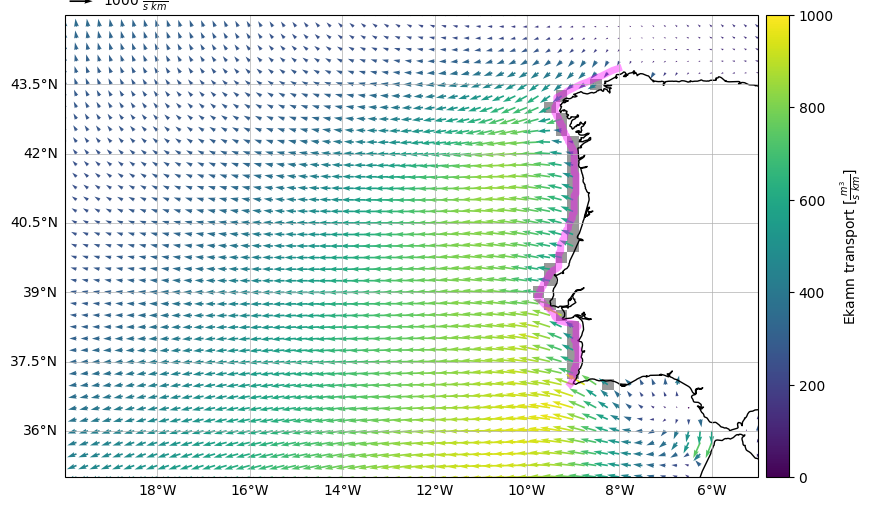

In [49]:
DS = Ek_summer.mean(dim = 'time')

# plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, -5, 45, 35])
ax.coastlines()
gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
gls.top_labels = False 
gls.right_labels = False  

ax.set_title('Mean Summer Ekman transport')

# show near shore mask 
DS.nsm.sel(lat = slice(37, 43.5)).plot(add_colorbar = False, cmap = 'Greys', alpha = 0.4)

col = np.hypot(DS.ek_trans_u * 1000 , DS.ek_trans_v * 1000)
im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u * 1000, DS.ek_trans_v * 1000, 
                         col, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 
qk = ax.quiverkey(im, 0.04, 1.03, 1*1000, r'1000 $\frac{m^3}{s \ km}$', labelpos='E')
plt.colorbar(im, label = r'Ekamn transport [$\frac{m^3}{s \ km}$]', pad = 0.01, fraction = 0.046);

# add mid-shelf line
plt.plot(mid_shelf_lon, mid_shelf_lat, color = 'magenta', lw = 5, alpha = 0.4);


Text(0.5, 1.0, 'Mean Summer Ekman transport')

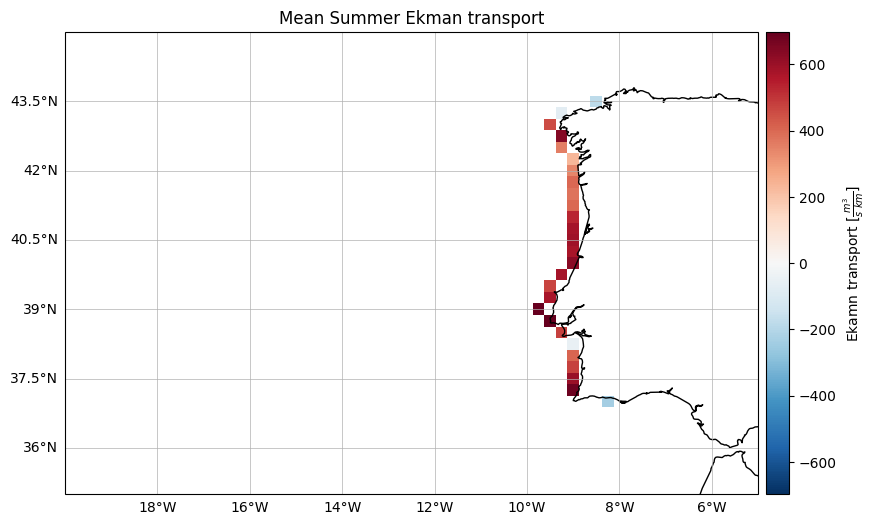

In [22]:
DS = Ek_summer.where(Ek_summer.nsm).mean(dim = 'time')

# plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, -5, 45, 35])
ax.coastlines()
gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
gls.top_labels = False 
gls.right_labels = False  


#col = np.hypot(DS.ek_trans_u * 1000 , DS.ek_trans_v * 1000)
#im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u * 1000, DS.ek_trans_v * 1000, 
#                         col, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 
#qk = ax.quiverkey(im, 0.04, 1.03, 1*1000, r'1000 $\frac{m^3}{s \ km}$', labelpos='E')
#plt.colorbar(im, label = r'Ekamn transport [$\frac{m^3}{s \ km}$]', pad = 0.01, fraction = 0.046);

im = (DS.UI_ns * 1000).plot(add_colorbar = False)
plt.colorbar(im, label = r'Ekamn transport [$\frac{m^3}{s \ km}$]', pad = 0.01, fraction = 0.046);

ax.set_title('Mean Summer Ekman transport')


In [40]:
Ek_summer_mean = Ek_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')
SST_summer_mean = SST_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')
SSH_summer_mean = SSH_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')

In [41]:
Ek_ns_summer_mean = Ek_summer_mean.UI_ns.mean(dim = ['lon', 'lat'], skipna = True)

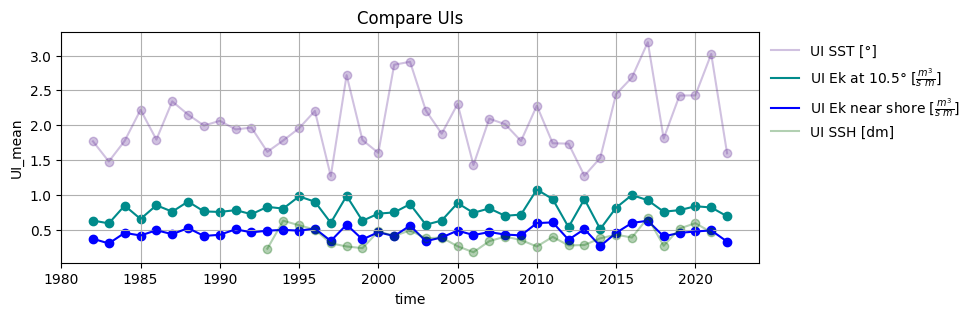

In [42]:
plt.figure(figsize = (9, 3))
SST_summer_mean.UI_mean.plot.scatter(color = 'rebeccapurple', alpha = 0.3)
SST_summer_mean.UI_mean.plot(color = 'rebeccapurple', alpha = 0.3, label = 'UI SST [°]')

Ek_summer_mean.UI_mean.plot.scatter(color = 'darkcyan', alpha = 1)
Ek_summer_mean.UI_mean.plot(color = 'darkcyan', alpha = 1, label = r'UI Ek at 10.5° [$\frac{m^3}{s \ m}$]')

Ek_ns_summer_mean.plot.scatter(color = 'blue', alpha = 1)
Ek_ns_summer_mean.plot(color = 'blue', alpha = 1, label = r'UI Ek near shore [$\frac{m^3}{s \ m}$]')

(SSH_summer_mean.UI_mean * 10).plot.scatter(color = 'darkgreen', alpha = 0.3)
(SSH_summer_mean.UI_mean * 10).plot(color = 'darkgreen', alpha = 0.3, label = 'UI SSH [dm]')

plt.grid()
plt.legend(bbox_to_anchor = (1, 1), edgecolor = 'none')
plt.title('Compare UIs');

In [22]:
result = pearsonr(Ek_summer_mean.UI_mean, Ek_ns_summer_mean)
print(f"Ek at 10.°W vs Ek mid-shelf UI \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")

Ek at 10.°W vs Ek mid-shelf UI 
  cor: 0.908 
  p-vlaue: 0.000


In [23]:
print('Ek vs SST \n')
result = pearsonr(Ek_summer_mean.UI_mean, SST_summer_mean.UI_mean)
print(f"Ek at 10.5°W vs SST UI \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f} \n")

result = pearsonr(Ek_ns_summer_mean, SST_summer_mean.UI_mean)
print(f"Ek at near shore vs SST UI \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")

Ek vs SST 

Ek at 10.5°W vs SST UI 
  cor: 0.425 
  p-vlaue: 0.006 

Ek at near shore vs SST UI 
  cor: 0.519 
  p-vlaue: 0.001


In [24]:
print('Ek vs SSH \n')
result = pearsonr(Ek_summer_mean.UI_mean.where(Ek_summer_mean.time == SSH_summer_mean.time), SSH_summer_mean.UI_mean)
print(f"Ek at 10.5°W vs SSH UI \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f} \n")

result = pearsonr(Ek_ns_summer_mean.where(Ek_ns_summer_mean.time == SSH_summer_mean.time), SSH_summer_mean.UI_mean)
print(f"Ek at near shore vs SSH UI \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")

Ek vs SSH 

Ek at 10.5°W vs SSH UI 
  cor: 0.181 
  p-vlaue: 0.347 

Ek at near shore vs SSH UI 
  cor: 0.293 
  p-vlaue: 0.123


In [25]:
# the mean summer correlation between my 'new and improved' Ekman transport and the other UIs is worse than just taking
# the mean UI Ek at 10.5°W ... kind of disappointing